### Basic setup


In the next few cells, we load some needed Python libraries and define some helper functions that let us interact with a Large Language Model (LLM).

For convenience, we make use of OpenAI's `openai` Python library that provides convenient access to the OpenAI API from applications written in the Python language. With this library, we can leverage several LLM-based endpoints offered by OpenAI to interact with an LLM. The library needs to be configured with your account's secret key 
which you can obtain by 1) creating an OpenAI account and 2) fetching the key from your account at https://platform.openai.com/account/api-keys





In [1]:
# OPENAI API key setup
import os
import openai
from tqdm import tqdm
import time

# we set OPENAI API key as the OPENAI_API_KEY environment variable before using the library
from dotenv import load_dotenv, find_dotenv
# find_dotenv searches for `.env` file in increasingly higher folders of this notebook.
# load_dotenv simply parses the found `.env` file and then loads all the variables found as environment variables.
_ = load_dotenv(find_dotenv())
openai.api_key = os.environ['OPENAI_API_KEY']

#set the path to the challenge dataset
DATA_DIR = '../data'

/Users/arnelcatangay/Documents/GitHub/llm_challenge_main/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


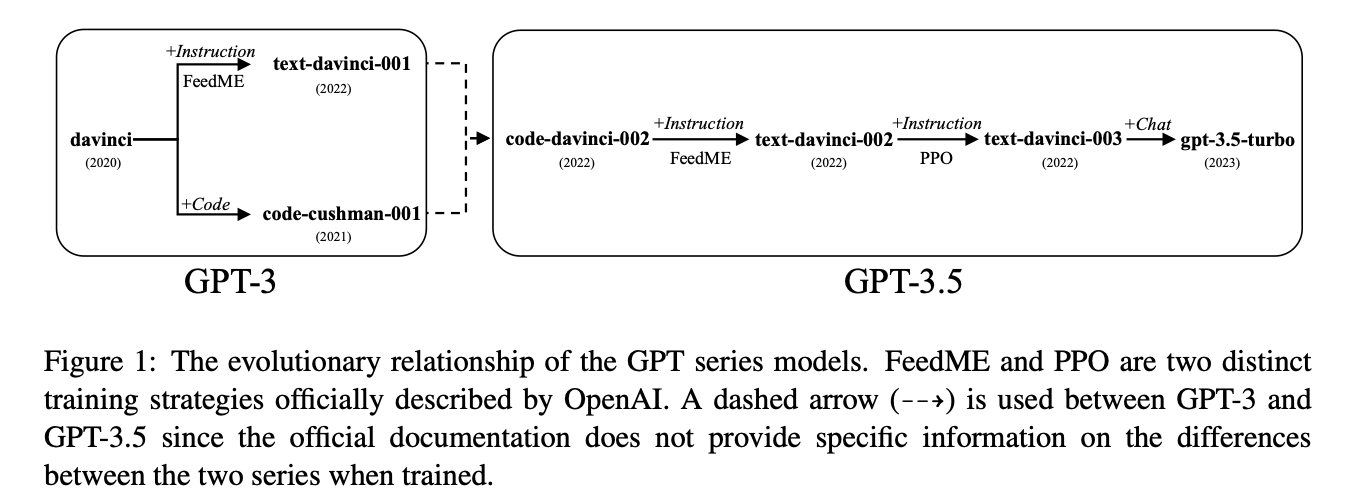

From https://arxiv.org/pdf/2303.10420v1.pdf

In [2]:
# Helper functions setup
def get_completion(prompt: str, is_chat_model=True) -> str:
    
    if is_chat_model:
        messages = [{"role": "user", "content": prompt}]
        response = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages= messages,
            temperature=0
        )
        return response.choices[0].message["content"]
    else:
        response = openai.Completion.create(
          model="text-davinci-002",
          prompt=prompt,
          temperature=0,
          max_tokens=100,
          top_p=1,
          frequency_penalty=0.0,
          presence_penalty=0.0,
          #stop="\n"
        )
        return response["choices"][0]["text"]
    

In [3]:
# With this setup, every interaction with the LLM (here GPT-3.5-Turbo) is a standalone interaction. With no context...

print(get_completion("Answer the following question(s): Who founded Analog Devices?"))
print(get_completion("Answer the following question(s): How do you know that?"))

Analog Devices was founded by Ray Stata and Matthew Lorber in 1965.
There are several ways to determine how we know something:

1. Personal experience: We may have firsthand knowledge or direct experience of a particular event, situation, or concept. This can include things we have seen, heard, felt, tasted, or smelled.

2. Observation: We can gather information and knowledge by observing the world around us. This can involve using our senses to perceive and understand phenomena or studying and analyzing data and evidence.

3. Education and learning: We acquire knowledge through formal education, such as attending school, college, or university. This includes learning from teachers, textbooks, lectures, and other educational resources.

4. Research and study: We can gain knowledge by conducting research, studying various sources, and examining existing information. This involves critically analyzing data, theories, and evidence to form conclusions.

5. Expertise and authority: We often

In [4]:
get_completion("Answer the following question(s): Who founded Analog Devices? How do you know that?")

'Analog Devices was founded by Ray Stata and Matthew Lorber in 1965. I know this because it is widely documented and mentioned in various sources, including the official company website, historical records, and business publications.'

In [16]:
# Try these
#get_completion("Could you recommend a voltage-to-current converter from ADI?")
# get_completion("What is 1B22?")

In [8]:
get_completion("What is the purpose of the Conditional Search ROM command in the DS28E04-100 module?")

'The purpose of the Conditional Search ROM command in the DS28E04-100 module is to search for devices on the 1-Wire bus that match a specific condition. This command allows the user to specify certain criteria, such as a specific family code or a specific set of bits in the ROM code, to search for devices that meet those criteria. It is a useful command for identifying and communicating with specific devices on the 1-Wire bus.'

In [18]:
# in a previous call of the above cell, we got:
# these models are getting updated
"As an AI language model, I don't have access to the full technical specifications of the DS28E04-100 module. However, based on my understanding of ROM commands in general, the purpose of the Conditional Search ROM command is to allow the user to search for a specific device on the 1-Wire bus based on certain criteria, such as its family code or unique serial number. This command can be useful in situations where multiple devices are connected to the bus and the user needs to communicate with a specific device without interfering with the others."

"As an AI language model, I don't have access to the full technical specifications of the DS28E04-100 module. However, based on my understanding of ROM commands in general, the purpose of the Conditional Search ROM command is to allow the user to search for a specific device on the 1-Wire bus based on certain criteria, such as its family code or unique serial number. This command can be useful in situations where multiple devices are connected to the bus and the user needs to communicate with a specific device without interfering with the others."

In [14]:
# let's see how well gpt-3.5-turbo does on the rest of questions:
import sys
sys.path.append("/Users/arnelcatangay/Documents/GitHub/llm_challenge_as23-main")
dset = "tutorial"
from llm_challenge.utils.misc import read_dict_from_json, write_dict_to_json
qas_fname = f"{DATA_DIR}/qas/qas_{dset}.json"
qas_dict = read_dict_from_json(qas_fname)

In [15]:
qas_dict["47"]

{'question': 'What is the purpose of the Conditional Search ROM command in the DS28E04-100 module?',
 'answer': 'The purpose of the Conditional Search ROM command in the DS28E04-100 module is to allow the bus master to identify devices on a multidrop system that fulfill certain conditions (CSR = 1) and have to signal an important event. Only those devices that fulfill the conditions will participate in the search. After each pass of the conditional search that successfully determined the 64-bit ROM code for a specific device on the multidrop bus, that particular device can be individually accessed as if a Match ROM had been issued, since all other devices will have dropped out of the search process and will be waiting for a reset pulse.',
 'datasheet': 'parsed/DS28E04-100.txt'}

In [16]:
gpt3p5_answers = {}
max_retries = 3
for q_id, qa_dict in (pbar := tqdm(qas_dict.items())):
    num_retries = 0
    while num_retries < max_retries:
        try:
            pbar.set_description(f"Answering question {q_id}")
            gpt3p5_answers[q_id] = get_completion(qa_dict["question"])
            break
        except Exception as e:
            num_retries +=1
            gpt3p5_answers[q_id] = 'I do not know.'


Answering question 50: 100%|██████████| 5/5 [00:25<00:00,  5.19s/it]


In [17]:
write_dict_to_json(f"gpt3p5_{dset}.json", gpt3p5_answers)

Evaluate `gpt3p5_answers` by running the following (this will consume your token budget - experiment on a smaller subset) in a terminal

```
cd llm_challenge
poetry shell
python scripts/evaluate.py --submission_json_path ./notebooks/gpt3p5_tutorial.json --reference_json_fname ./data/qas/qas_tutorial.json --submission_evaluation_json_fname ./notebooks/gpt3p5_tutorial_evaluation.json
```
This gets us 60% accuracy: 3 correct out of 5.

Similarly, on `train` dataset, we can evaluate as follows.

```
cd llm_challenge
poetry shell
python scripts/evaluate.py --submission_json_path ./notebooks/gpt3p5_train.json --reference_json_fname ./data/qas/qas_train.json --submission_evaluation_json_fname ./notebooks/gpt3p5_evaluation.json
```

This gets us 66% accuracy: 124 questions answered correctly out of 187.

In [18]:
# Looking up graded question. It looks like question 50 was not answered correctly
q_id = "50"
qa_dict = qas_dict[q_id]
print(qa_dict)
get_completion(qa_dict["question"])

{'question': 'What is the recommended range for the value of C1 in the LTC7804 module and why is it chosen in that range?', 'answer': 'The recommended range for the value of C1 in the LTC7804 module is 0.1μF to 0.47μF. It is chosen in that range to force R1 || R2 to around 2k, reducing error that might have been caused by the SENSE− pin’s ±1μA current.', 'datasheet': 'parsed/ltc7804.txt'}


'The recommended range for the value of C1 in the LTC7804 module is typically between 1μF and 10μF. This value is chosen based on the required stability and transient response of the module.\n\nC1 is the input capacitor that filters the input voltage and provides a stable supply to the module. It helps in reducing the input voltage ripple and noise, ensuring proper operation of the module. The value of C1 affects the stability and transient response of the module.\n\nA larger value of C1, such as 10μF, provides better filtering and stability, reducing the input voltage ripple and noise. This is beneficial in applications where the input voltage may have significant fluctuations or noise.\n\nOn the other hand, a smaller value of C1, such as 1μF, may be sufficient in applications with a more stable input voltage. It still provides some filtering and stability, but with a smaller physical size and cost.\n\nThe recommended range of 1μF to 10μF allows designers to choose the appropriate val

In [ ]:
# Looking up graded question. It looks like question 50 was not answered correctly
q_id = "50"
qa_dict = qas_dict[q_id]
print(qa_dict)
get_completion(qa_dict["question"])

In [ ]:
# Looking up graded question. It looks like question 50 was not answered correctly
q_id = "50"
qa_dict = qas_dict[q_id]
print(qa_dict)
get_completion(qa_dict["question"])

In [19]:
# let's provide gpt3p5 with some contexts to the questions
contexts_fname = f"{DATA_DIR}/qas/contexts_{dset}.json"
contexts_dict = read_dict_from_json(contexts_fname)

In [20]:
context = contexts_dict[q_id]
question = qa_dict["question"]
prompt = """
I will give you a piece of text from electrical/electronic module's datashet delimted by ---
Your task is to give a detailed answer to the question that follows the text based on the provided text.
If the text does not contain sufficient information to answer, just say I do not know.

Here is the text:
---
{context}
---
Question: {question}
Answer:
"""

get_completion(prompt.format(context=context, question=question), is_chat_model=True)

"The recommended range for the value of C1 in the LTC7804 module is usually selected to be in the range of 0.1μF to 0.47μF. This range is chosen to force R1 || R2 to around 2k, which helps reduce error that might have been caused by the SENSE− pin's ±1μA current. By selecting C1 within this range, the equivalent resistance R1 || R2 can be calculated from the nominal inductance, C1 value, and DCR. This allows for proper scaling of the maximum inductor DCR to the desired sense resistor value (RD). Therefore, the recommended range for C1 is chosen to ensure accurate measurement and scaling of the sense resistor value."

In [21]:
context

'drop across the external capacitor is equal to the drop \nacross the inductor DCR multiplied by R2/(R1 + R2)R2 scales the voltage across the sense terminals for appli -\ncations where the DCR is greater than the target sense \nresistor valueTo properly dimension the external filter \ncomponents, the DCR of the inductor must be knownIt can be measured using a good RLC meter , but the DCR \ntolerance is not always the same and varies with tempera -\nture; consult the manufacturers’ data sheets for detailed informationUsing the inductor ripple current value from the Inductor \nValue Calculation section, the target sense resistor value is:\n RSENSE ≤VSENSE(MAX)\nIL(MAX) +ΔIL\n2\nTo ensure that the application will deliver full load cur -\nrent over the full operating temperature range, choose the \nminimum value for the maximum current sense threshold \nVSENSE(MAX)  in the Electrical Characteristics tableNext, determine the DCR of the inductor When provided, \nuse the manufacturer’s maxim